# Image Classification: Chest X-Ray analysis to predict presence of Lung Pathologies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import cv2
import os
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras import applications
from keras import callbacks
from keras.optimizers import Adam
from keras_efficientnets import EfficientNetB0

import warnings
warnings.filterwarnings('ignore')

First Steps:
- Deciding image size to standardizing the images
- "Hardcoding" the labels so the for loop
- Create function to make paths based on the labels

In [2]:
img_size = 150
labels = ['PNEUMONIA', 'NORMAL']

def get_data(data_dir):
    data = []
    
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e )
    return np.array(data)

In [3]:
# Assigning variables to the path that contains the documents (images)
train = get_data('CellData/chest_xray/train')
test = get_data('CellData/chest_xray/test')

In [4]:
train.shape

(5232, 2)

<AxesSubplot:ylabel='count'>

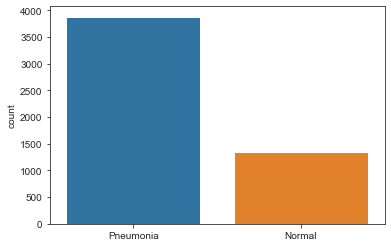

In [5]:
# Checking for the distribuition of our data
# Here we notice we have way more pneumonia images than healthy ones (over 2x)

temp_labels = []
for x in train:
    if(x[1] == 0):
        temp_labels.append("Pneumonia")
    else:
        temp_labels.append("Normal")
sns.set_style('ticks')
sns.countplot(temp_labels)

Text(0.5, 1.0, 'PNEUMONIA')

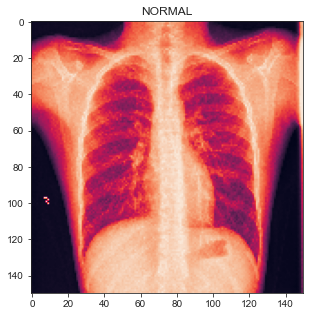

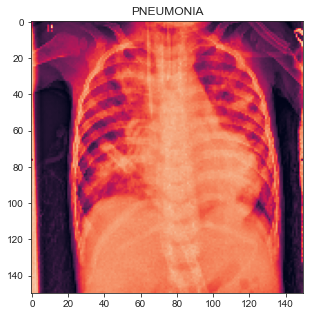

In [6]:
# How those images look like?

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[0][0])
plt.title(labels[train[0][1]])

In [7]:
# We create a validation set, since we don't have one, that is 10% of the original train set

train_set, val_set = train_test_split(train, test_size=0.10, random_state=22)

In [8]:
print("The number of files in the train set is: {}, in the validation set is: {} and in the test set is: {}"
      .format(len(train_set), len(val_set), len(test)))

The number of files in the train set is: 4708, in the validation set is: 524 and in the test set is: 624


In [9]:
# Here we create a for loop to make our x's and y's to use for modeling and validation

x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train_set:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val_set:
    x_val.append(feature)
    y_val.append(label)

In [10]:
# Transforming the data into arrays and normalizing it

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [11]:
# Reshaping and assigning variables that we gonna use for modeling

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [12]:
# Data Augmentation

data_generated = ImageDataGenerator(
        rotation_range = 30,  
        zoom_range = 0.2, 
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        horizontal_flip = True,  
        vertical_flip=False)  


data_generated.fit(x_train)

### Now we apply the model

Here we define the layers and how they are going to be.

In [13]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [14]:
# We create a method to reduce the possibility of plateaus


learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.3, min_lr=0.000001)

In [15]:
# We fit the model, after some tries we stick with 16 for the batch size and 30 epochs

history = model.fit(data_generated.flow(x_train,y_train, batch_size = 16) ,epochs = 30 , validation_data = data_generated.flow(x_val, y_val), callbacks = [learning_rate_reduction])

Epoch 1/30
295/295 [==============================] - 228s 774ms/step - loss: 0.5260 - accuracy: 0.8078 - val_loss: 7.5561 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 2/30
295/295 [==============================] - 233s 790ms/step - loss: 0.3709 - accuracy: 0.8632 - val_loss: 9.1184 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 3/30
295/295 [==============================] - 227s 769ms/step - loss: 0.2999 - accuracy: 0.8932 - val_loss: 1.4023 - val_accuracy: 0.7366 - lr: 0.0010
Epoch 4/30
295/295 [==============================] - 217s 737ms/step - loss: 0.2754 - accuracy: 0.9002 - val_loss: 2.0572 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 5/30
295/295 [==============================] - 217s 736ms/step - loss: 0.2502 - accuracy: 0.9167 - val_loss: 1.9642 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 6/30
295/295 [==============================] - 214s 727ms/step - loss: 0.2136 - accuracy: 0.9220 - val_loss: 0.9438 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 7/30
295/295 [==========================

In [16]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 5s 259ms/step - loss: 0.2116 - accuracy: 0.9391
Loss of the model is -  0.211628258228302
20/20 [==============================] - 5s 261ms/step - loss: 0.2116 - accuracy: 0.9391
Accuracy of the model is -  93.91025900840759 %


## Visualization of Results

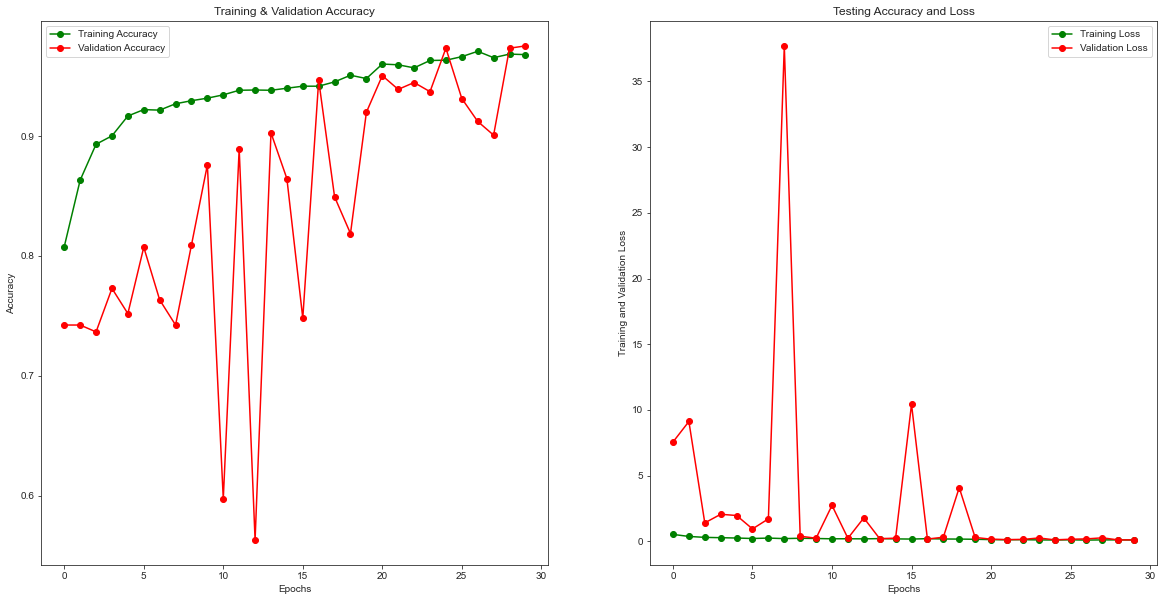

In [18]:
# We plot the graph and realize that the performance is sufficient. 
# The Accuracy is doing well, starting to stabilize on the validation and the loss is stable after epoch ~20

epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy and Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training and Validation Loss")

plt.show()

In [49]:
# We define the predictions so we can use on the classification matrix and report

predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]

In [20]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.95      0.95      0.95       390
   Normal (Class 1)       0.92      0.91      0.92       234

           accuracy                           0.94       624
          macro avg       0.94      0.93      0.93       624
       weighted avg       0.94      0.94      0.94       624



In [24]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test,predictions)

array([[372,  18],
       [ 20, 214]], dtype=int64)

In [25]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

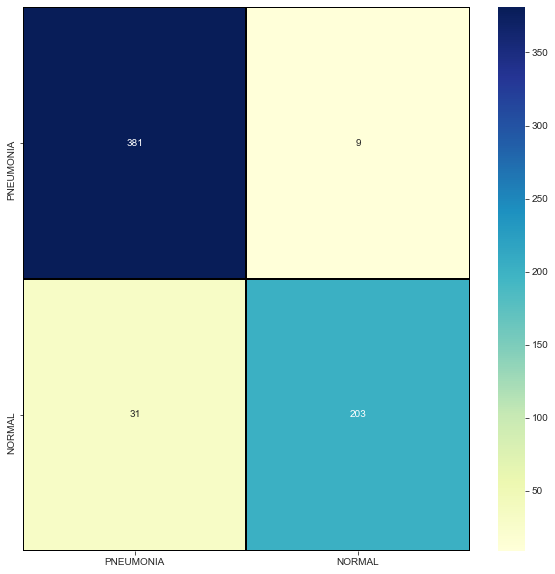

In [50]:
# Visualizing the Confusion Matrix
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "YlGnBu", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [27]:
# We define what are the cases of corrects and incorrects predictions for further investigation and improvement of the model

correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

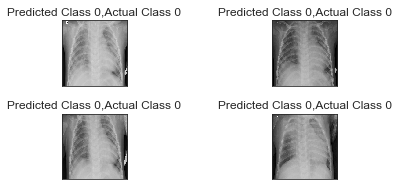

In [29]:
# Analyzing the correct answers
i = 0
for c in correct[:4]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

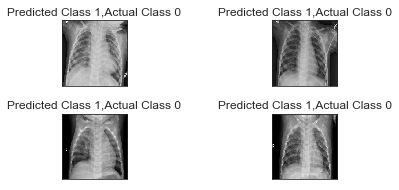

In [30]:
# Trying to find the ones that the computer got it wrong
i = 0
for c in incorrect[:4]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

### For here on we try different approaches on the modeling
- We try making the cnn wider and deeper to see if the results improve in any way

In [32]:
model0 = Sequential()
model0.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model0.add(BatchNormalization())
model0.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model0.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model0.add(Dropout(0.1))
model0.add(BatchNormalization())
model0.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model0.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model0.add(BatchNormalization())
model0.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model0.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model0.add(Dropout(0.1))
model0.add(BatchNormalization())
model0.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model0.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model0.add(BatchNormalization())
model0.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model0.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model0.add(Dropout(0.1))
model0.add(BatchNormalization())
model0.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model0.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model0.add(BatchNormalization())
model0.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model0.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model0.add(Dropout(0.2))
model0.add(BatchNormalization())
model0.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model0.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model0.add(Dropout(0.2))
model0.add(BatchNormalization())
model0.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model0.add(Flatten())
model0.add(Dense(units = 128 , activation = 'relu'))
model0.add(Dropout(0.2))
model0.add(Dense(units = 1 , activation = 'sigmoid'))
model0.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 64)       

In [33]:
history_2 = model0.fit(data_generated.flow(x_train,y_train, batch_size = 32) ,epochs = 30 , validation_data = data_generated.flow(x_val, y_val), callbacks = [learning_rate_reduction])

Epoch 1/30
148/148 [==============================] - 159s 1s/step - loss: 0.3655 - accuracy: 0.8292 - val_loss: 2.0485 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 2/30
148/148 [==============================] - 143s 964ms/step - loss: 0.2857 - accuracy: 0.8845 - val_loss: 4.9417 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 3/30
148/148 [==============================] - 145s 978ms/step - loss: 0.2394 - accuracy: 0.9012 - val_loss: 5.2274 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 4/30
148/148 [==============================] - 144s 973ms/step - loss: 0.2098 - accuracy: 0.9116 - val_loss: 0.5213 - val_accuracy: 0.8626 - lr: 0.0010
Epoch 5/30
148/148 [==============================] - 144s 971ms/step - loss: 0.1971 - accuracy: 0.9225 - val_loss: 0.3704 - val_accuracy: 0.8416 - lr: 0.0010
Epoch 6/30
148/148 [==============================] - 141s 955ms/step - loss: 0.1903 - accuracy: 0.9263 - val_loss: 0.2435 - val_accuracy: 0.8989 - lr: 0.0010
Epoch 7/30
148/148 [=============================

In [34]:
print("Loss of the model is - " , model0.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model0.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 87ms/step - loss: 0.1721 - accuracy: 0.9359
Loss of the model is -  0.17212074995040894
20/20 [==============================] - 2s 88ms/step - loss: 0.1721 - accuracy: 0.9359
Accuracy of the model is -  93.58974099159241 %


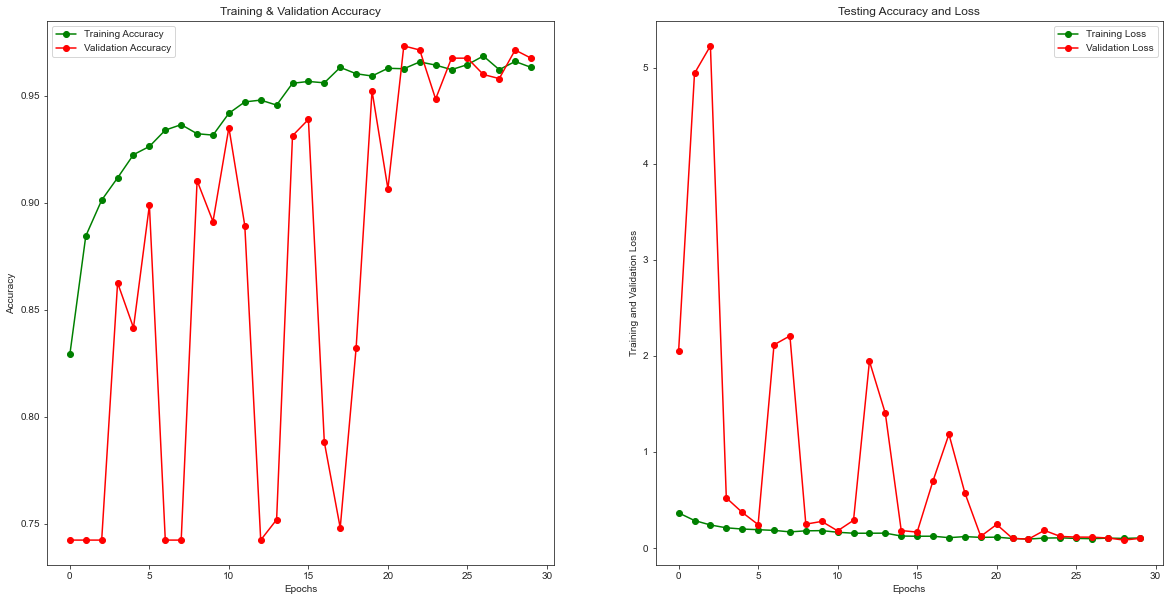

In [36]:
# We plot the graph and realize that the performance is sufficient. 
# The Accuracy is doing well, starting to stabilize on the validation and the loss is stable after epoch ~20

epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history_2.history['accuracy']
train_loss = history_2.history['loss']
val_acc = history_2.history['val_accuracy']
val_loss = history_2.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy and Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training and Validation Loss")

plt.show()

In [37]:
# We define the predictions so we can use on the classification matrix and report

predictions = model0.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:10]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [38]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.98      0.95       390
   Normal (Class 1)       0.96      0.87      0.91       234

           accuracy                           0.94       624
          macro avg       0.94      0.92      0.93       624
       weighted avg       0.94      0.94      0.94       624



In [39]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test,predictions)

array([[381,   9],
       [ 31, 203]], dtype=int64)

In [40]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

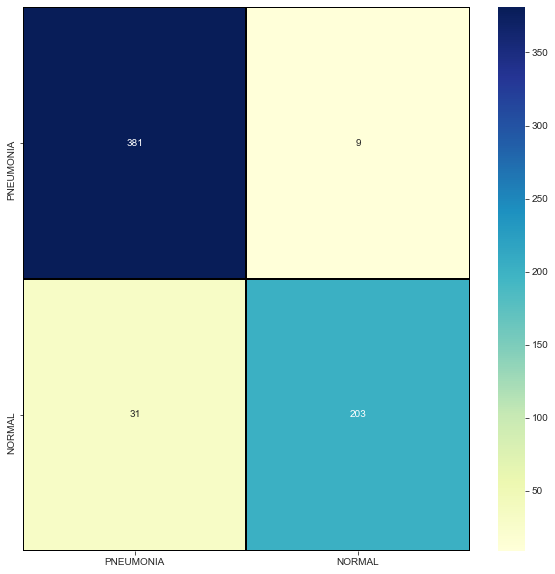

In [41]:
# Visualizing the Confusion Matrix

plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "YlGnBu", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [42]:
# We define what are the cases of corrects and incorrects predictions for further investigation and improvement of the model

correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

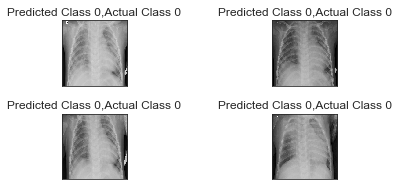

In [44]:
# Analyzing the correct answers

i = 0
for c in correct[:4]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

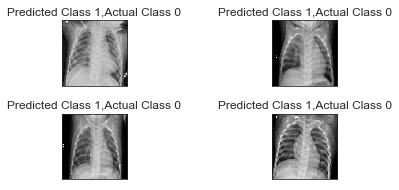

In [45]:
# Trying to find the ones that the computer got it wrong

i = 0
for c in incorrect[:4]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

### 3th model

In [46]:
model1 = Sequential()
model1.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(Dropout(0.3))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(Dropout(0.3))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Flatten())
model1.add(Dense(units = 128 , activation = 'relu'))
model1.add(Dropout(0.3))
model1.add(Dense(units = 1 , activation = 'sigmoid'))
model1.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_10 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 38, 38, 64)       

In [47]:
history_3 = model1.fit(data_generated.flow(x_train,y_train, batch_size = 8) ,epochs = 30 , validation_data = data_generated.flow(x_val, y_val), callbacks = [learning_rate_reduction])

Epoch 1/30
589/589 [==============================] - 198s 336ms/step - loss: 0.6223 - accuracy: 0.8018 - val_loss: 0.5075 - val_accuracy: 0.7557 - lr: 0.0010
Epoch 2/30
589/589 [==============================] - 202s 343ms/step - loss: 0.4162 - accuracy: 0.8466 - val_loss: 0.2331 - val_accuracy: 0.9237 - lr: 0.0010
Epoch 3/30
589/589 [==============================] - 209s 355ms/step - loss: 0.3702 - accuracy: 0.8723 - val_loss: 1.6477 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 4/30
589/589 [==============================] - 226s 383ms/step - loss: 0.3775 - accuracy: 0.8828 - val_loss: 0.4216 - val_accuracy: 0.8588 - lr: 0.0010
Epoch 5/30
589/589 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8921
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
589/589 [==============================] - 199s 338ms/step - loss: 0.3204 - accuracy: 0.8921 - val_loss: 0.7974 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 6/30
589/589 [====================

In [48]:
print("Loss of the model is - " , model1.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model1.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 117ms/step - loss: 0.3015 - accuracy: 0.8478
Loss of the model is -  0.3014862537384033
20/20 [==============================] - 2s 118ms/step - loss: 0.3015 - accuracy: 0.8478
Accuracy of the model is -  84.77563858032227 %


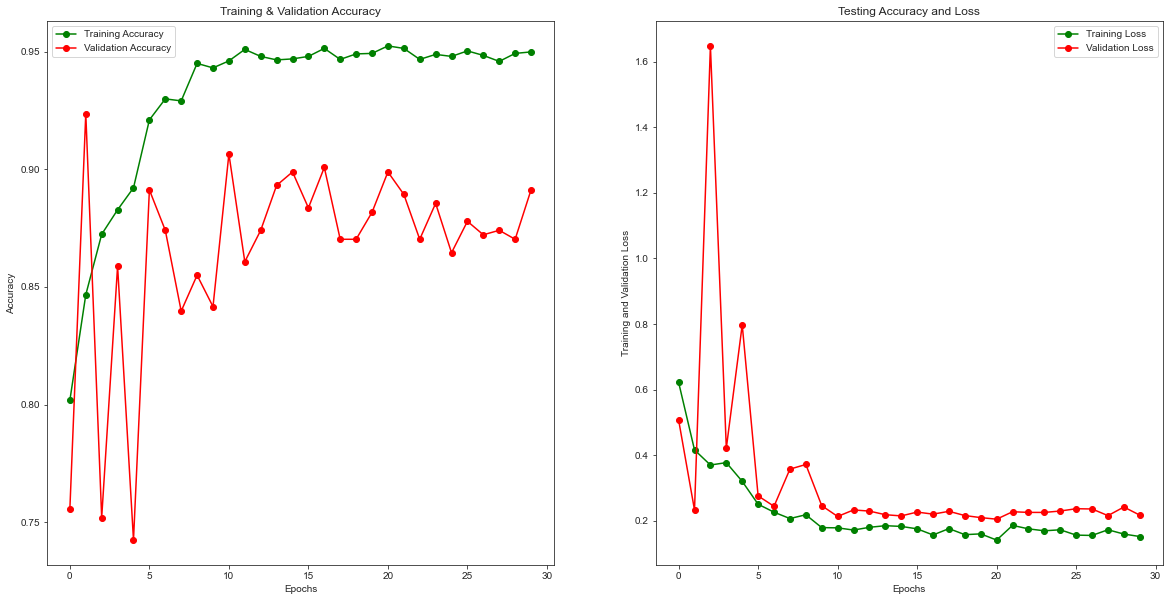

In [52]:
# We plot the graph and realize that the performance is sufficient. 
# The Accuracy is doing well, starting to stabilize on the validation and the loss is stable after epoch ~20

epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history_3.history['accuracy']
train_loss = history_3.history['loss']
val_acc = history_3.history['val_accuracy']
val_loss = history_3.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy and Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training and Validation Loss")
plt.show()

In [53]:
# We define the predictions so we can use on the classification matrix and report

predictions = model1.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [54]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.81      0.99      0.89       390
   Normal (Class 1)       0.99      0.60      0.75       234

           accuracy                           0.85       624
          macro avg       0.90      0.80      0.82       624
       weighted avg       0.87      0.85      0.84       624



In [55]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test,predictions)

array([[388,   2],
       [ 93, 141]], dtype=int64)

In [56]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

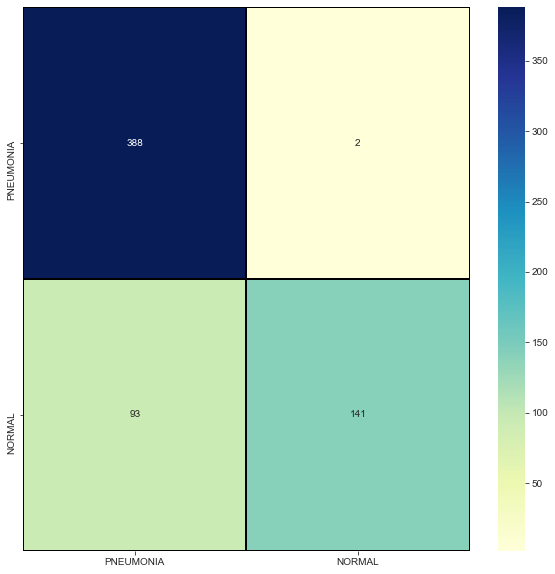

In [57]:
# Visualizing the Confusion Matrix
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "YlGnBu", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [58]:
# We define what are the cases of corrects and incorrects predictions for further investigation and improvement of the model

correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

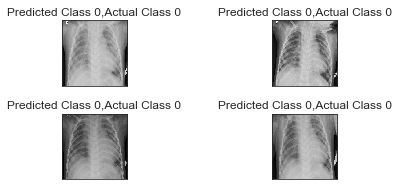

In [62]:
# Analyzing the correct answers

i = 0
for c in correct[:4]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

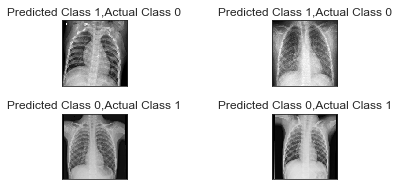

In [61]:
# Trying to find the ones that the computer got it wrong

i = 0
for c in incorrect[:4]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1